In [39]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks
from tensorflow.keras import utils

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

compat_rename = {'Ultimate Tensile Strength': 'Tensile Strength, Ultimate',
                 'Yield Strength': 'Tensile Strength, Yield',
                 'Elongation': 'Elongation at Break',
                 'names': 'Name'}

In [40]:
nickel_data = pd.read_csv("final_test.csv", index_col=0)
nickel_data = nickel_data.drop(columns=["Name","URL", "Unnamed: 46", "Density"])
# nickel_data = nickel_data.rename(columns={"Name":"name"})
nickel_data.head()

,"Tensile Strength, Ultimate","Tensile Strength, Yield",Elongation at Break,Al,B,C,Cr,Fe,Mn,Ni,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,1440.0,1265.0,5.3,4.5,0.01,0.05,16.0,3.0,0.5,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
1,490.0,248.0,23.0,0.0,0.00,0.01,22.0,3.0,0.5,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,970.0,565.0,42.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,620.0,410.0,42.0,0.0,0.00,0.05,25.0,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,895.0,490.0,43.8,0.4,0.00,0.10,21.0,5.0,0.5,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train for Yield

In [41]:
# uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
# uts_data = uts_data.drop(
#     columns=['Tensile Strength, Yield', 'Elongation at Break'])
# uts_data = uts_data.fillna(0)
# uts_data = uts_data.astype("float32")

yield_data = nickel_data.dropna(subset="Tensile Strength, Yield")
yield_data = yield_data.drop(columns=['Tensile Strength, Ultimate', 'Elongation at Break'])
yield_data = yield_data.fillna(0)
yield_data = yield_data.astype("float32")

yield_data.head()

,"Tensile Strength, Yield",Al,B,C,Cr,Fe,Mn,Ni,Si,Y,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,1265.0,4.5,0.01,0.05,16.0,3.0,0.5,75.0,0.20,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,248.0,0.0,0.00,0.01,22.0,3.0,0.5,56.0,0.08,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,565.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,410.0,0.0,0.00,0.05,25.0,0.0,0.0,65.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,490.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:

yield_train_data = yield_data.sample(frac=0.8, random_state=2212)
yield_test_data = yield_data.drop(yield_train_data.index)

yield_data.head()

,"Tensile Strength, Yield",Al,B,C,Cr,Fe,Mn,Ni,Si,Y,...,Pb,O,Re,Se,Ag,Zn,Nd,Pd,Ru,Th
0,1265.0,4.5,0.01,0.05,16.0,3.0,0.5,75.0,0.20,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,248.0,0.0,0.00,0.01,22.0,3.0,0.5,56.0,0.08,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,565.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,410.0,0.0,0.00,0.05,25.0,0.0,0.0,65.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,490.0,0.4,0.00,0.10,21.0,5.0,0.5,62.0,0.50,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
yield_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
"Tensile Strength, Yield",1454.0,6.933235e+02,338.738068,30.0,400.000000,700.000,940.000000,1999.000000
Al,1454.0,1.565031e+00,1.963939,0.0,0.100000,0.500,2.500000,25.004999
B,1454.0,1.229849e-02,0.196912,0.0,0.000000,0.004,0.011000,7.500000
C,1454.0,6.947799e-02,0.347579,0.0,0.020000,0.050,0.080000,13.001000
Cr,1454.0,1.596830e+01,6.823433,0.0,14.000000,17.420,20.000000,49.500000
Fe,1454.0,6.696173e+00,10.502695,0.0,0.000000,2.000,8.000000,50.000000
Mn,1454.0,3.109735e-01,0.602978,0.0,0.000000,0.070,0.500000,14.250500
Ni,1454.0,5.910035e+01,12.800231,20.0,53.349998,57.410,63.664999,100.000000
Si,1454.0,2.591344e-01,0.657072,0.0,0.000000,0.080,0.400000,19.000500
Y,1454.0,1.873885e-02,0.145054,0.0,0.000000,0.000,0.000000,1.968556


In [44]:
yield_train_features = yield_train_data.copy()
yield_test_features = yield_test_data.copy()

yield_train_labels = yield_train_features.pop("Tensile Strength, Yield")
yield_test_labels = yield_test_features.pop("Tensile Strength, Yield")

In [45]:
yield_normalizer = hf.normalize(yield_train_features)

First example: [[ 0.    0.    0.04 16.5   9.5   0.8  72.5   0.4   0.    0.    0.    0.
   0.    0.    0.    0.3   0.    0.    0.    0.01  0.01  0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.  ]]

Normalized: [[-0.8  -0.06 -0.08  0.08  0.27  0.81  1.05  0.21 -0.13 -0.07 -0.78 -0.9
  -0.44 -0.2  -0.62 -0.43 -0.03 -0.13 -0.03  0.05  1.05 -0.3  -0.11 -0.1
  -0.06 -0.04 -0.03 -0.21 -0.03 -0.04 -0.13 -0.04 -0.04 -0.03 -0.04  0.
   0.    0.   -0.05]]


In [46]:
def builder(hp): return hf.model_builder_variable(hp,
                                                  yield_normalizer,
                                                  test_layers=[1,2,3],
                                                  dropout=0.5,
                                                  layer_1_nodes=[50,100,150,200,250],
                                                  layer_2_nodes=[50,100,150,200,250],
                                                  layer_3_nodes=[50,100,150,200,250])

In [47]:
# tuner = kt.RandomSearch(builder,
#                      objective='val_loss',
#                      max_trials=100,
#                      overwrite=True,
#                      directory='model_search',
#                      project_name='yield_model')

tuner = kt.Hyperband(builder,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     overwrite=False,
                     directory='model_search',
                     project_name='yield_model_no_heat')

tuner_es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)

In [48]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 4
hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
layer_1_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_2_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}
layer_3_nodes (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150, 200, 250], 'ordered': True}


In [49]:
tuner.search(yield_train_features, yield_train_labels, epochs=200, validation_split=0.2, callbacks=[tuner_es], verbose=2)


Trial 254 Complete [00h 00m 08s]
val_loss: 95501.7265625

Best val_loss So Far: 89194.7734375
Total elapsed time: 00h 08m 01s
INFO:tensorflow:Oracle triggered exit


In [50]:
tuner.results_summary()

Results summary
Results in model_search\yield_model_no_heat
Showing 10 best trials
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 250
layer_2_nodes: 250
layer_3_nodes: 200
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0243
Score: 89194.7734375
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 150
layer_2_nodes: 100
layer_3_nodes: 250
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 90756.7265625
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 150
layer_2_nodes: 200
layer_3_nodes: 200
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0206
Score: 92927.9140625
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_nodes: 150
layer_2_nodes: 150
layer_3_nodes: 250
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0230
Score: 93274.15625
Trial summary
Hyperparameters:
hidden_layers: 3
layer_1_n

In [51]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [52]:
best_hps.get_config()['values']

{'hidden_layers': 3,
 'layer_1_nodes': 250,
 'layer_2_nodes': 250,
 'layer_3_nodes': 200,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0243'}

In [53]:
yield_model = tuner.hypermodel.build(best_hps)

yield_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 39)               79        
 ion)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 39)                0         
                                                                 
 dense_4 (Dense)             (None, 250)               10000     
                                                                 
 dropout_5 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 250)               62750     
                                                                 
 dropout_6 (Dropout)         (None, 250)               0         
                                                      

In [54]:
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

# history = yield_model.fit(yield_train_features, yield_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

history = yield_model.fit(yield_train_features, yield_train_labels, epochs=20000, validation_split=0.2, verbose=0)

In [55]:
# utils.plot_model(yield_model, show_layer_activations=True, show_shapes=True)

In [56]:
yield_model.evaluate(yield_test_features, yield_test_labels, verbose=1)

12/12 [==============================] - 0s 910us/step - loss: 52184.8672 - root_mean_squared_error: 228.4401 - mean_absolute_error: 167.9449


[52184.8671875, 228.44007873535156, 167.94491577148438]

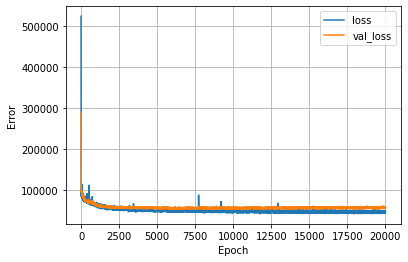

In [57]:
hf.plot_loss(history)

12/12 [==============================] - 0s 819us/step


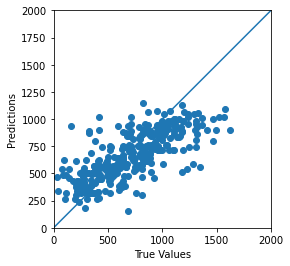

In [58]:
test_predictions = yield_model.predict(yield_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(yield_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)